In [1]:
#!/usr/bin/env python

In [2]:
import os
import sys
if os.path.exists('/home/chieh/code/wPlotLib'):
	sys.path.insert(0,'/home/chieh/code/wPlotLib')
if os.path.exists('/home/chieh/code/wuML'):
	sys.path.insert(0,'/home/chieh/code/wuML')

In [3]:
import wuml
import numpy as np
import torch
import torch
import torch.nn as nn

In [4]:
def costFunction(x, x̂, ẙ, y, ŷ, ind):	
#	x -> encoder -> x̂
#	x̂ -> encoder_linear_output -> ẙ	
#	x̂ -> decoder -> ŷ	
#	possible autoencoder objective λ could be 0
#	loss = (x - ŷ)ᒾ + λ * objective(ẙ, y)
#
#	This function can return 1 value or 3 values in a list
#	if return 1 value, just the loss
#	if return 3 values, [total_loss, reconstruction_loss, extra network from ẙ loss]
#
#	In this example, we perform both reconstruction and CE loss
#
	CE_loss = nn.CrossEntropyLoss() #weird pytorch, dim of y is 1, and ŷ is 20x3
	R = torch.sum((x - ŷ) ** 2)/(128*13)	#scaled by batch size times data dimension
	mse = torch.sum((ẙ - y) ** 2)/(128)	#scaled by batch size times data dimension
	loss = R + mse
	return [loss, R, mse]

In [5]:
def costFunction2(x, x̂, ẙ, y, ŷ, ind):	
#	Example of just return 1 value, this is just a regular autoencoder
	return torch.sum((x - ŷ) ** 2)

In [6]:
data = wuml.wData('../../data/shap_regress_example_uniform.csv', label_column_name='label', label_type='continuous', 
				preprocess_data='center and scale',	first_row_is_label=True)

In [7]:
[X_train, X_test, y_train, y_test] = wuml.split_training_test(data, test_percentage=0.2)

In [8]:
AE = wuml.autoencoder(12, X_train, default_depth=2, costFunction=costFunction, # costFunction and costFunction2 both works
						max_epoch=1000, encoder_output_weight_structure=[(1,'none')] ) 
AE.fit()

	epoch: 1000, Total Loss/dimension: 0.4300, Reconstruct loss: 0.0052, Objective loss: 0.4248, Learning Rate: 0.00000049

Result of the data reconstruction

In [9]:
ŷ = AE(data)
print('\n\n')
recontructed = wuml.pretty_np_array(ŷ[0:5,0:5], front_tab='', title='recontruction')
original = wuml.pretty_np_array(data.X[0:5,0:5], front_tab=' ', title='original')
wuml.block_two_string_concatenate(recontructed, original, spacing='\t', auto_print=True)

This is the bottleneck output which is d=12

In [10]:
x̂ = AE.reduce_dimension(data, output_type='wData')
wuml.jupyter_print(x̂)
print('\n')

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.210193,0.517331,0.234516,-0.945902,0.276434,0.040120,-1.017748,-0.552444,0.067371,0.022585,0.431119,-0.068767
1,0.058206,0.373253,-0.487155,-0.641991,0.368885,-0.188446,-1.829949,-1.382692,0.530733,1.075318,0.251348,-1.082487
2,-0.076944,-0.775505,0.122567,-0.993706,-0.520315,0.542652,-0.180531,-0.861129,-0.669885,0.228350,0.589070,0.794975
3,1.261568,1.038137,1.454516,-0.944214,0.277449,1.103518,0.032916,0.533976,0.318121,-0.702450,0.568949,0.618079
4,-0.271643,1.553858,-0.627936,-0.731382,1.064681,-1.338400,-2.650597,-1.009928,0.659702,0.477376,0.052680,-1.547424
...,...,...,...,...,...,...,...,...,...,...,...,...
25,-0.465643,-0.704980,-0.944905,-0.559983,-0.289916,-0.155315,-1.416630,-1.857814,-0.140504,1.482422,0.250273,-0.600832
26,0.079270,0.891220,-0.169893,-0.521984,0.361901,-0.430558,-1.388079,-0.652770,0.237589,0.472979,0.094452,-0.602435
27,0.202476,1.279094,-0.209849,-0.857428,0.962902,-0.558673,-2.280821,-0.974721,0.858784,0.486454,0.273945,-1.357447
28,-0.084049,-0.267526,0.072467,-0.692783,-0.438490,0.196223,-0.209178,-0.564331,-0.642975,0.211156,0.326936,0.666597


This is the objective network output Training error

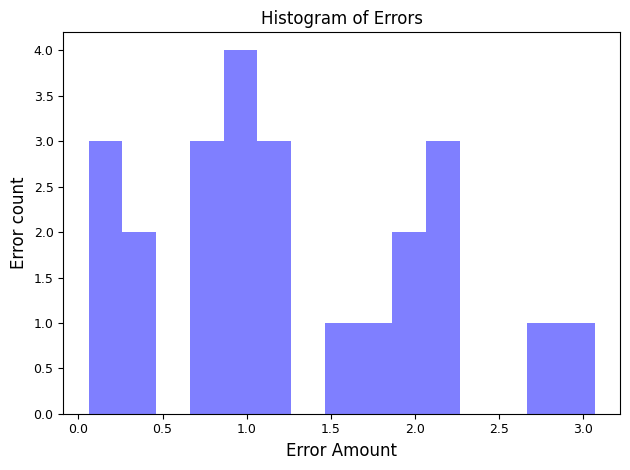

,y,ŷ,Δy
12,-5.72,-8.79,3.07
13,3.58,6.28,2.70
16,5.76,8.01,2.25
19,-4.14,-6.35,2.21
23,-8.05,-10.19,2.14
18,-4.35,-6.34,1.99
10,-5.67,-7.59,1.92
8,3.38,5.12,1.74
20,1.90,3.43,1.53
17,-1.00,-2.25,1.25


In [11]:
ẙ = AE.objective_network(X_train)
res = wuml.output_regression_result(y_train, ẙ, sort_by='error')

This is the objective network output Test error

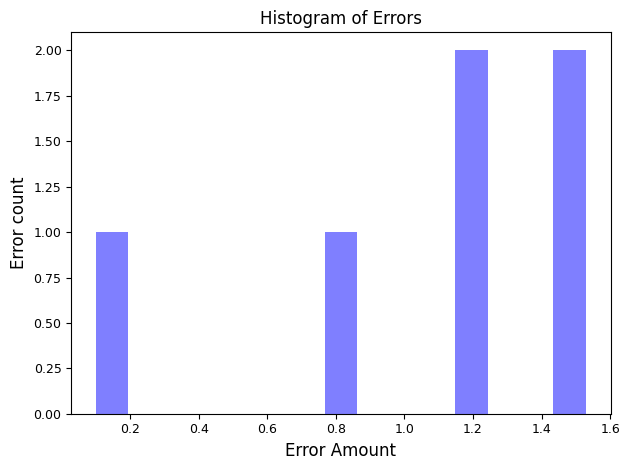

,y,ŷ,Δy
3,0.20,-1.33,1.53
2,-0.05,1.48,1.53
4,-2.61,-3.78,1.17
5,-2.31,-3.46,1.15
0,-5.91,-6.71,0.80
1,-0.21,-0.31,0.10


In [12]:
ẙ = AE.objective_network(X_test)
res = wuml.output_regression_result(y_test, ẙ, sort_by='error')